## Import essential libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

## Mount drive to import dataset and YOLO model weights

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
from IPython.display import clear_output, display, Image

## Install ```ultralytics``` library

In [ ]:
!pip install ultralytics
clear_output()

## Install ```easyOCR``` library for OCR operation

In [ ]:
!pip install easyocr
clear_output()

## Unzip YOLO model weights

In [ ]:
!unzip -xq '.../odometer_detection_model.zip'

In [ ]:
from ultralytics import YOLO
import easyocr

yolov8_model = YOLO("/content/content/runs/detect/train/weights/best.pt")
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

## Do odometer detection using YOLO

In this part, I used the YOLO model to detect the odometer part from images and then crop and save the image.

In [ ]:
val_dir = '.../images/val'
images = sorted(glob(val_dir+'/*'))

if os.path.exists('odometers'):
  os.makedirs('odometers')

for image in images:
  result = yolov8_model.predict(source=image, conf=0.25, stream=False)
  result[0].save_crop(f"/content/odometers/{image.split('/')[-1].split('.')[0]}")

## OCR operation

First of all, we need to do some preprocessing on images. And after that feed this image to OCR model. I used easyOCR library.

In [ ]:
def preprocess_and_detect_text(image_path):
    croped_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to a larger size
    resized_image = cv2.resize(croped_image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized_image, (5, 5), 0)

    # Apply adaptive thresholding to enhance text
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply sharpening filter
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(binary, -1, kernel)

    # Increase contrast
    alpha = 2.0  # Simple contrast control
    beta = 0     # Simple brightness control
    contrasted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

    # Detect text using EasyOCR
    ocr_results = reader.readtext(contrasted, allowlist='0123456789')
    detected_text = ' '.join([res[1] for res in ocr_results])

    return contrasted, detected_text

## Do detection and plot the results

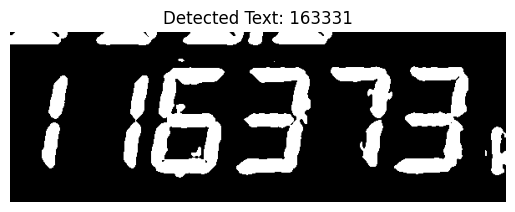

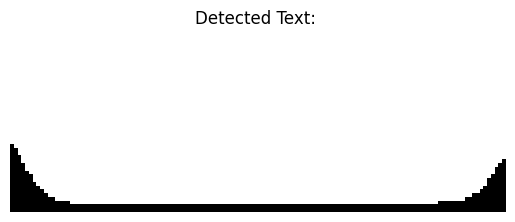

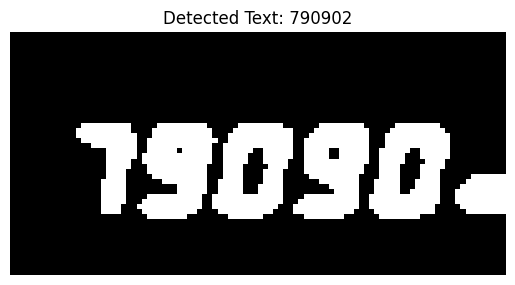

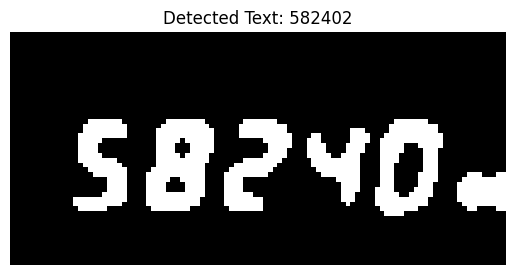

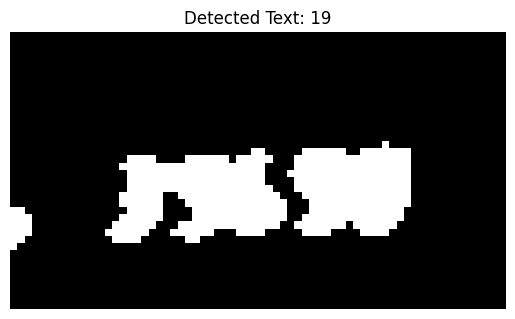

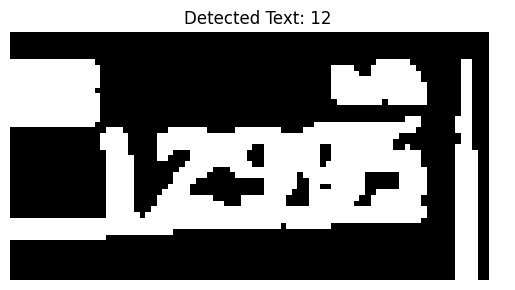

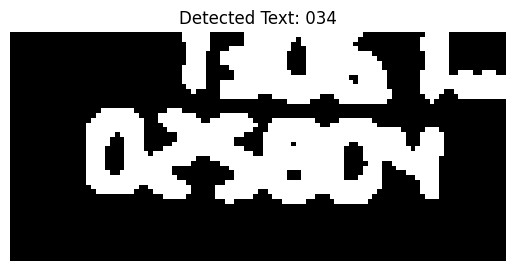

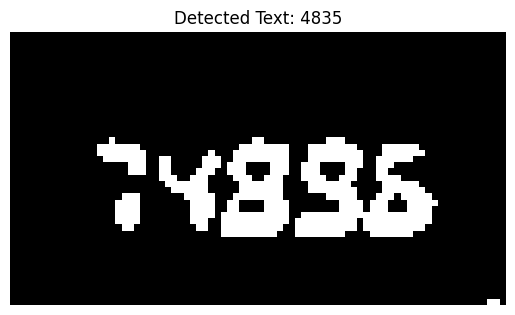

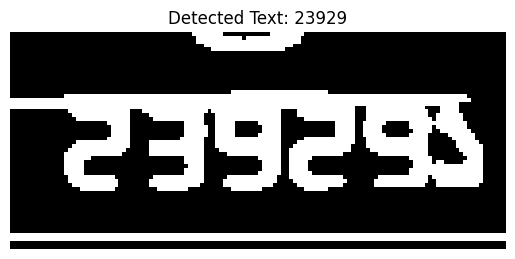

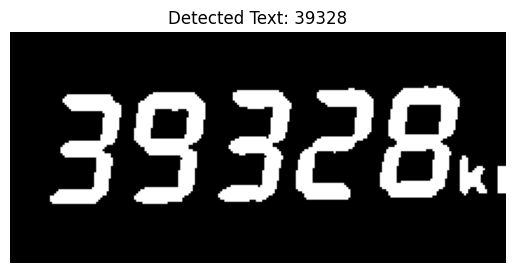

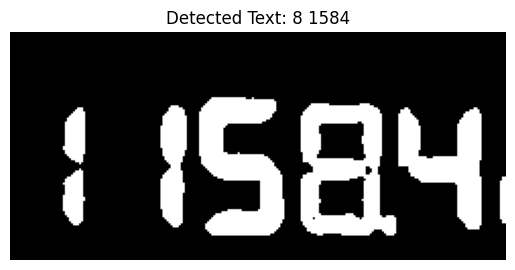

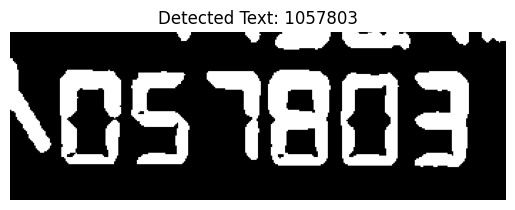

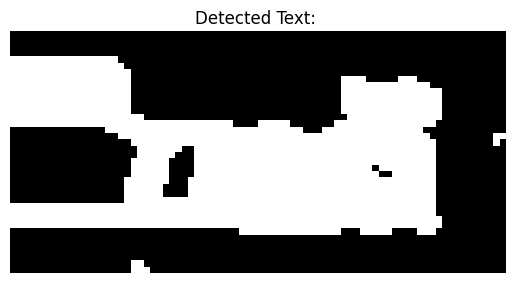

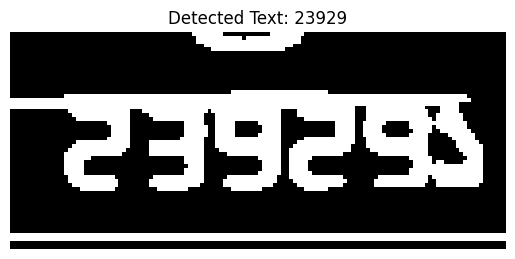

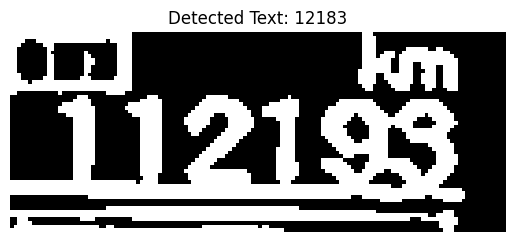

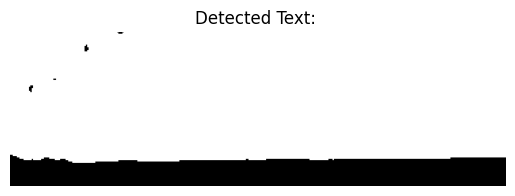

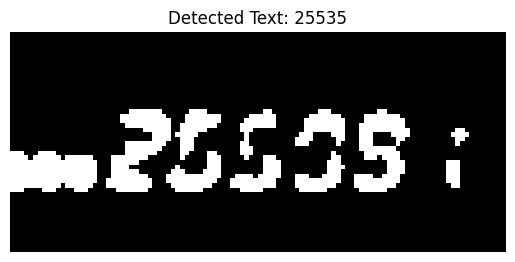

In [ ]:
for dir in sorted(glob('/content/odometers/*')):
  for img in os.listdir(f'{dir}/odometer'):
    contrasted, detected_text = preprocess_and_detect_text(os.path.join(dir, 'odometer', img))
    plt.imshow(contrasted, cmap='gray')
    plt.title(f'Detected Text: {detected_text}')
    plt.axis('off')
    plt.show()